In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #plotting library provides 2D & 3D plots

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
sales = pd.read_csv("sample data.csv")
sales.head(10)

,id,order_number,date,ordertype,total_amount
0,17776403,2318005440715,2023-12-30,Bill Payment,15.0
1,17776400,2318005437490,2023-12-30,Bill Payment,10.0
2,17776398,2318005435185,2023-12-30,Bill Payment,30.0
3,17776395,2318005432937,2023-12-30,Bill Payment,10.0
4,17776394,2318005431507,2023-12-30,Bill Payment,15.0
5,17776393,2318005430112,2023-12-30,Buy Product,99.0
6,17776392,2318005429908,2023-12-30,Bill Payment,50.0
7,17776389,2318005426505,2023-12-30,Bill Payment,100.0
8,17776387,2318005424897,2023-12-30,Bill Payment,10.0
9,17776386,2318005423692,2023-12-30,Bill Payment,10.0


Check Null Values

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584025 entries, 0 to 584024
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            584025 non-null  int64  
 1   order_number  584025 non-null  int64  
 2   date          584025 non-null  object 
 3   ordertype     582472 non-null  object 
 4   total_amount  584025 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 22.3+ MB


Converting date from Object to dateTime

In [5]:
sales['date'] = pd.to_datetime(sales["date"])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584025 entries, 0 to 584024
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            584025 non-null  int64         
 1   order_number  584025 non-null  int64         
 2   date          584025 non-null  datetime64[ns]
 3   ordertype     582472 non-null  object        
 4   total_amount  584025 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 22.3+ MB


Converting Date to a Month period, then sum the number of items in each month

In [6]:
sales['date'] = sales['date'].dt.to_period("M")
monthly_sales = sales.groupby('date').sum().reset_index()

In [7]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [8]:
monthly_sales.head(10)

,date,id,order_number,ordertype,total_amount
0,2023-09-01,4027232807181,552606168374528634,Buy e-VoucherBuy e-VoucherBuy e-VoucherBill Pa...,21233371.45
1,2023-10-01,2689934842439,361052933973137504,Bill PaymentBill PaymentBill PaymentBill Payme...,13581503.98
2,2023-11-01,2042851254655,270322818454996093,Bill PaymentBill PaymentBill PaymentBuy e-Vouc...,12120059.49
3,2023-12-01,1295363573043,169458202489756902,Bill PaymentBill PaymentBill PaymentBill Payme...,10324303.91


Visualization

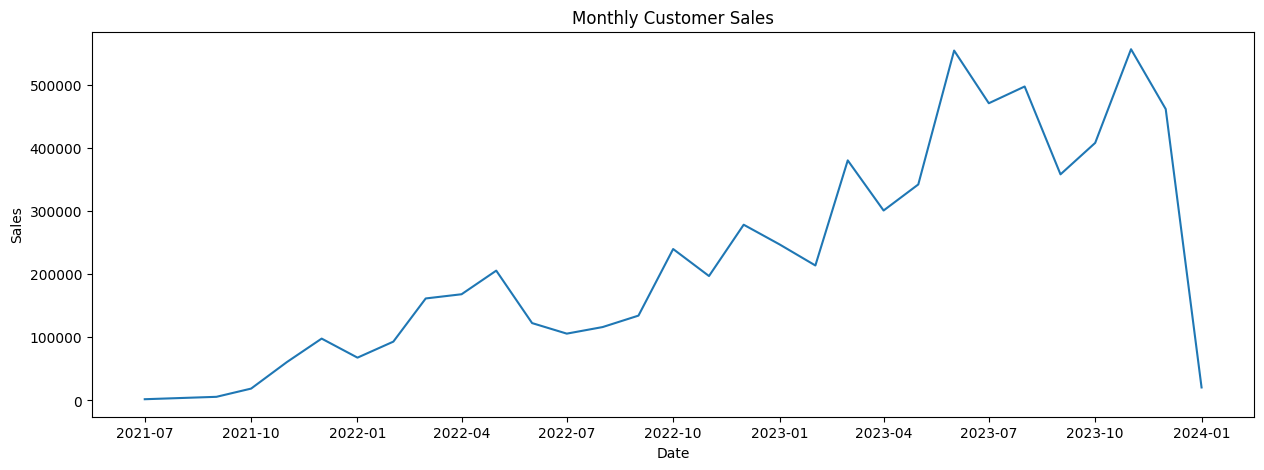

In [9]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['sales_date'], monthly_sales['sales_amount'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

Call the difference on the sales columns to make the sales data stationary
*Difference between last month

In [10]:
monthly_sales['sales_diff'] = monthly_sales['sales_amount'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,sales_date,sales_amount,sales_diff
1,2021-09-01,5800.00,3800.00
2,2021-10-01,18835.80,13035.80
3,2021-11-01,60893.70,42057.90
4,2021-12-01,97978.94,37085.24
5,2022-01-01,67826.43,-30152.51
6,2022-02-01,93168.20,25341.77
7,2022-03-01,161542.38,68374.18
8,2022-04-01,168195.51,6653.13
9,2022-05-01,205575.87,37380.36
10,2022-06-01,122536.78,-83039.09


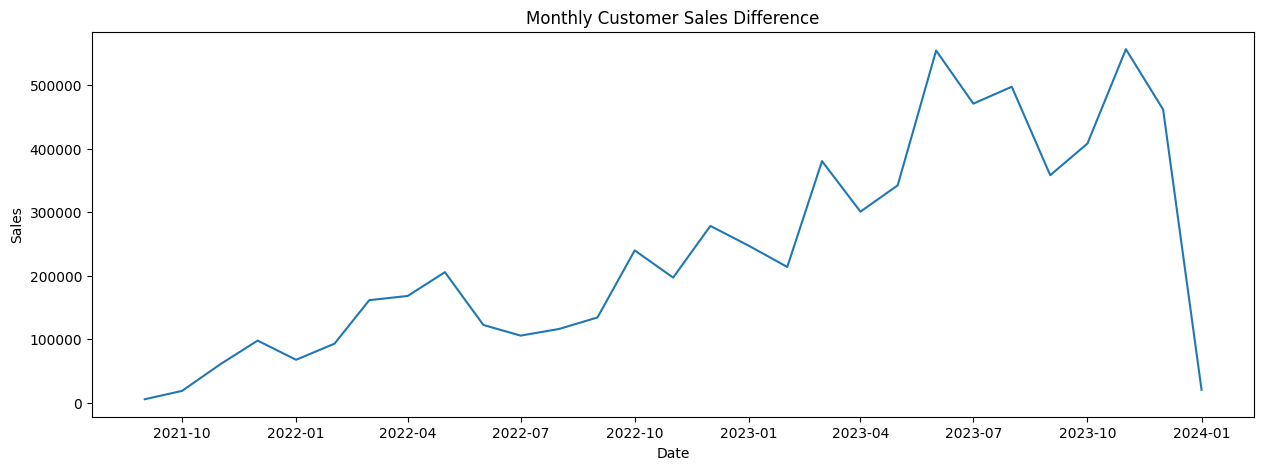

In [11]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['sales_date'], monthly_sales['sales_amount'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show()

Dropping off sales_date and sales_amount bcs we only need Stationary data

In [12]:
supervised_data = monthly_sales.drop(['sales_date', 'sales_amount'], axis=1)

Prepare Supervised Data (Previous 12 months sales will be the input features, Next 12 months sales will be the output )

In [13]:
for i in range (1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,18120.41,10406.57,-16697.69,-83039.09,37380.36,6653.13,68374.18,25341.77,-30152.51,37085.24,42057.90,13035.80,3800.00
1,105427.56,18120.41,10406.57,-16697.69,-83039.09,37380.36,6653.13,68374.18,25341.77,-30152.51,37085.24,42057.90,13035.80
2,-42745.10,105427.56,18120.41,10406.57,-16697.69,-83039.09,37380.36,6653.13,68374.18,25341.77,-30152.51,37085.24,42057.90
3,81230.75,-42745.10,105427.56,18120.41,10406.57,-16697.69,-83039.09,37380.36,6653.13,68374.18,25341.77,-30152.51,37085.24
4,-31141.01,81230.75,-42745.10,105427.56,18120.41,10406.57,-16697.69,-83039.09,37380.36,6653.13,68374.18,25341.77,-30152.51
5,-33393.24,-31141.01,81230.75,-42745.10,105427.56,18120.41,10406.57,-16697.69,-83039.09,37380.36,6653.13,68374.18,25341.77
6,166409.03,-33393.24,-31141.01,81230.75,-42745.10,105427.56,18120.41,10406.57,-16697.69,-83039.09,37380.36,6653.13,68374.18
7,-79368.73,166409.03,-33393.24,-31141.01,81230.75,-42745.10,105427.56,18120.41,10406.57,-16697.69,-83039.09,37380.36,6653.13
8,41237.66,-79368.73,166409.03,-33393.24,-31141.01,81230.75,-42745.10,105427.56,18120.41,10406.57,-16697.69,-83039.09,37380.36
9,211980.11,41237.66,-79368.73,166409.03,-33393.24,-31141.01,81230.75,-42745.10,105427.56,18120.41,10406.57,-16697.69,-83039.09


Split data into Train & Test

In [14]:
train_data = supervised_data[:-12] #Previous 12 months
test_data = supervised_data[-12:] #Upcoming 12 months
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (5, 13)
Test Data Shape:  (12, 13)


In [15]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [16]:
X_train, y_train = train_data[:,1:], train_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (5, 12)
y_train Shape:  (5,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


Make prediction data frame to merge the predicted sales prices of all trained algs

In [17]:
sales_dates = monthly_sales['sales_date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [18]:
act_sales = monthly_sales['sales_amount'][-13:].to_list()
print(act_sales)

[247138.27, 213745.03, 380154.06, 300785.33, 342022.99, 554003.1, 470593.89, 497106.1, 358022.34, 407839.96, 556129.0700000001, 461383.27, 20616.010000000002]


To create Linear Regression Model & Predicted Output

In [19]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [20]:
lr_pre = lr_pre.reshape(-1, 1)
#This is a set matrix - contains the input features of the test data, and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [21]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name= "Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index=True)

In [22]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales_amount'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales_amount'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales_amount'][-12:])
#print(predict_df)

print("Linear Regression MSE: ", lr_mse ) #Mean Squared Error
print("Linear Regression MAE: ", lr_mae ) #Mean Absolute Error
print("Linear Regression R2: ", lr_r2 )

Linear Regression MSE:  234954.78964749677
Linear Regression MAE:  137414.94869924613
Linear Regression R2:  -1.7430618101696038


VIsualization of the prediction against the actual sales

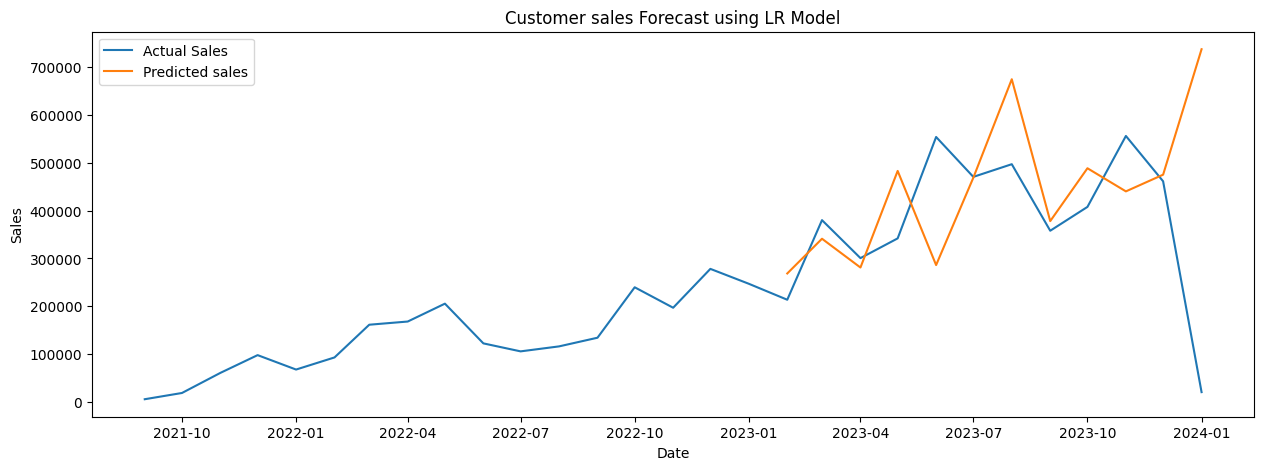

In [23]:
plt.figure(figsize=(15,5))
# Actual sales
plt.plot(monthly_sales['sales_date'], monthly_sales['sales_amount'])
# Predicted sales
plt.plot(predict_df['sales_date'], predict_df['Linear Prediction'])
plt.title("Customer sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted sales'])
plt.show()

In [24]:
predicted_sales_lr = [lr_pre_test_set[index][0] + act_sales[index] for index in range(len(lr_pre_test_set))]

In [25]:
predict_df['Linear Prediction'] = predicted_sales_lr

In [26]:
print("Linear Regression Predicted Sales:")
print(predict_df['Linear Prediction'])

Linear Regression Predicted Sales:
0     268699.580071
1     341274.829063
2     281120.495604
3     483033.272833
4     286230.598489
5     468862.112866
6     674703.083508
7     378140.984161
8     488628.491049
9     440298.661761
10    475175.614481
11    737455.306071
Name: Linear Prediction, dtype: float64
